In [1]:
import pandas as pd
import numpy as np

import os
import sys
sys.path.append('../../pycore/')
from simulate import RBA_result
from utils import extract_details_from_rxnid

import matplotlib.pyplot as plt
import matplotlib.patches as mp
import matplotlib.lines as mlines
from gsm_custom_functions import *
%matplotlib inline

In [2]:
datasets = []
sigfigs = 2
df_kapp = pd.read_excel('../../build_model/input/precursors/RekenaEtAl2023/kapp-comparisons.xlsx', sheet_name='all datasets')
# rows below AD5 and AG5 contain the raw data (log scaling done later), while row above contains column names
df_kapp = df_kapp.iloc[2:]
df_kapp.columns = df_kapp.iloc[0]
df_kapp = df_kapp.iloc[1:]

# take only columns AD thru AG
df_kapp = df_kapp.iloc[:, 29:33]

# remove empty rows
df_kapp = df_kapp.dropna()

# update index, excluding the first row
# select data and axis labels
df_kapp.columns = ['subsystem', 'name', 'rtRBA $k_{app}$ ($h^{-1}$)', 'scRBA $k_{app}$ ($h^{-1}$)']
df_kapp.index = range(len(df_kapp))
# show the data
df_kapp

,subsystem,name,rtRBA $k_{app}$ ($h^{-1}$),scRBA $k_{app}$ ($h^{-1}$)
0,Starch and sucrose metabolism,13GS_c_FWD-rt7616,561171.130789,115909.407874
1,Cell wall biosynthesis,16GS_c_FWD-rt0150,59929.602569,51281.369019
2,Cell wall biosynthesis,16GS_c_FWD-rt3279,59929.602569,51281.369019
3,Transport,2OXOADPt_c_m_FWD-rt2267,990193.160224,172355.370467
4,Fatty acid elongation,3HACD260_rm_FWD-rt2309,11720.010088,632265.519842
...,...,...,...,...
354,"Valine, leucine and isoleucine metabolism",VALTA_m_REV-rt6242_m,59914.795941,47302.578884
355,Aminoacyl-tRNA biosynthesis,VALTRS_c_FWD-rt8160_c,27666.462991,18299.229615
356,Pyrimidine metabolism,YUMPS_c_REV-rt6068,0.0,0.0
357,Pyrimidine metabolism,YUMPS_c_REV-rt7720,0.0,0.0


In [3]:
df_prot = pd.read_excel('/Users/ejm6426/Library/CloudStorage/OneDrive-ThePennsylvaniaStateUniversity/Labs/Maranas Lab/rtRBA/SCvsRT.xlsx',
						sheet_name='comparing-proteins',usecols=[0,8,9])
# remove empty rows
df_prot = df_prot.dropna()
# convert from scientific notation to float (last 2 columns)
# df_prot.iloc[:,1:] = df_prot[:,1:].apply(pd.to_numeric, errors='coerce')
# df_prot.iloc[:,1:] = df_prot.iloc[:,1:].applymap(lambda x: '%.2f' % x)
# df_prot = df_prot.apply(pd.to_numeric, errors='coerce')

df_prot

,SC name,SC data.1,B_frac.1
0,Q0045,0.002798,0.000037
1,Q0080,0.000011,0.000002
2,Q0085,0.000199,0.000088
3,Q0105,0.016497,0.005359
4,Q0250,0.000473,0.000283
...,...,...,...
587,YPL023C,0.000152,0.000389
588,YPL028W,0.000148,0.000593
589,YPL036W,0.000032,0.000183
590,YPL040C,0.000007,0.000025


In [4]:
model1 = cobra.io.load_json_model('../../build_model/input/iRhtoC.json')
model2 = cobra.io.load_json_model('../../build_model/input/precursors/GSM_iSace1144.json')

In [5]:
df_flux = pd.read_excel('/Users/ejm6426/Documents/rtRBA-main/build_model/input/precursors/RekenaEtAl2023/RxnMatches.xlsx',
						sheet_name='MFA',skiprows=2)
# remove empty rows
# count cases where sign differs
# diff_sign = {'total': set(), 'excluding_zero': set(), 'sub'}
diff_sign = 0
diff_sign_excluding_zero = 0
points_with_diff_sign = {}

model1col = 'SC / glc'
# model1col = 'log(SC)'
# model1col = 'SC'
model2col = 'RT / glc'
# model2col = 'log(RT)'
# model2col = 'RT'
units = '($mmol\ gDW^{-1}h^{-1}$)' 
if model2col == 'RT / glc':
	units = '/ glucose uptake ($mmol/mmol\ glc$)'
# remove all columns that aren't the index or aren't named model1col, model2col
df_flux = df_flux[['rxn', 'subsystem', model2col, model1col]]

# make extra dataframe without rows where model1col and model2col are both zero or non-numbers
df_flux = df_flux[(df_flux[model1col] != 0) | (df_flux[model2col] != 0)].dropna(subset=[model1col, model2col])
# df_flux_no_zeros = df_flux[(df_flux[model1col] != 0) | (df_flux[model2col] != 0)].dropna(subset=[model1col, model2col])
df_flux_no_zeros = df_flux

# find rxns with sign differences that aren't caused by equations being reversed
for index, row in df_flux.iterrows():
	if np.sign(row[model1col]) != np.sign(row[model2col]):
		# compare reaction equations to see if they are the same
		# get reaction IDs
		rxn = row['rxn']
		if rxn in model1.reactions:
			if rxn in model2.reactions:
				rxn1 = model1.reactions.get_by_id(rxn)
				rxn2 = model2.reactions.get_by_id(rxn)
				if rxn1.reaction != rxn2.reaction:
					print('Reaction', rxn1, 'differs between models')
					# show rxn equations
					print('Model 1:', rxn1.reaction)
					print('Model 2:', rxn2.reaction)
		# 	else:
		# 		print('Reaction', rxn1, 'not found in', model2.id)
		# else:
		# 	print('Reaction', rxn1, 'not found in', model1.id)
# compare correlations in fluxes across subsystems
# get unique subsystems
subsystems = df_flux_no_zeros['subsystem'].unique()
# get correlation for each subsystem
correlations = {}
for subsystem in subsystems:
	print(subsystem)
	df_subsystem = df_flux_no_zeros[df_flux_no_zeros['subsystem'] == subsystem]
	# compare model1col and model2col
	df_subsystem = df_subsystem.apply(pd.to_numeric, errors='coerce')
	# find R^2 value
	correlations[subsystem] = np.corrcoef(df_subsystem[model1col], df_subsystem[model2col])[0,1]**2
	# find number of points in each subsystem
	correlations[subsystem] = (correlations[subsystem], 'n='+str(len(df_subsystem)))
	# df_subsystem = df_subsystem.apply(pd.to_numeric, errors='coerce')
	# correlations[subsystem] = df_subsystem.corr().iloc[0,1]
# remove NaN values
correlations = {key: value for key, value in correlations.items() if not np.isnan(value[0])}
print('Correlations:')
# sort from most to least correlated
correlations = dict(sorted(correlations.items(), key=lambda item: item[1], reverse=True))
# make TSV file with subsystem, correlation, and number of points
with open('SC_vs_RT_flux_correlations.tsv', 'w') as f:
	headers='Subsystem\tCorrelation\tNumber of points\n'
	f.write(headers)
	print(headers.replace('\n', ''))
	for key, value in correlations.items():
		line=key+'\t'+str(value[0])+'\t'+value[1]+'\n'
		f.write(line)
		print(line.replace('\n', ''))
# find fraction of points in subsystems with abs(correlation) > 0.6
correlations = {key: value for key, value in correlations.items() if abs(value[0]) > 0.36}
print('Subsystems with R^2 > 0.36:', len(correlations))
# correlations = {key: value for key, value in correlations.items() if value[0] > 0.8}
# print('Subsystems with R^2 > 0.8:', len(correlations))
# % of points in these subsystems
total_points = len(df_flux_no_zeros)
points_in_subsystems = 0
for key in correlations.keys():
	points_in_subsystems += len(df_flux_no_zeros[df_flux_no_zeros['subsystem'] == key])
print('Fraction of points in these subsystems:', points_in_subsystems/total_points,'\n')

print('Number of cases where sign differs:', diff_sign)
print('Number of cases where sign differs, excluding zero values:', diff_sign_excluding_zero)
if diff_sign_excluding_zero > 0:
	print('Points with different signs, excluding zero values:')
	for key, value in points_with_diff_sign.items():
		print(key, value)
	# find most common subsystems for these points
	subsystems = {}
	for key in points_with_diff_sign.keys():
		subsystem = df_flux[df_flux['rxn'] == key]['subsystem'].values[0]
		if subsystem in subsystems:
			subsystems[subsystem] += 1
		else:
			subsystems[subsystem] = 1
	print('\nSubsystems:')
	# sort from most to least common
	subsystems = dict(sorted(subsystems.items(), key=lambda item: item[1], reverse=True))
	for key, value in subsystems.items():
		print(str(key)+': '+str(value))
# use absolute values
df_flux[model1col] = df_flux[model1col].abs()
df_flux[model2col] = df_flux[model2col].abs()
df_flux

Reaction AKGCITta_m: akg_c + cit_m <=> akg_m + cit_c differs between models
Model 1: akg_c + cit_m <=> akg_m + cit_c
Model 2: akg_c + cit_m --> akg_m + cit_c
Reaction FADH2t_c_m: fadh2_c --> fadh2_m differs between models
Model 1: fadh2_c --> fadh2_m
Model 2: fadh2_m --> fadh2_c
Reaction Ktps_e: h_e + k_e <=> h_c + k_c differs between models
Model 1: h_e + k_e <=> h_c + k_c
Model 2: h_e + k_e --> h_c + k_c
Starch and sucrose metabolism
Cell wall biosynthesis
Transport
Lysine metabolism
Alanine, aspartate and glutamate metabolism
Terpenoid backbone biosynthesis
Amino sugar and nucleotide sugar metabolism
Arginine and proline metabolism
Valine, leucine and isoleucine metabolism
Acetyl-CoA synthesis
Pyruvate metabolism
Citric acid cycle
Purine metabolism
Glycine, serine and threonine metabolism
Cysteine and methionine metabolism
Phenylalanine, tyrosine and tryptophan metabolism
Pyrimidine metabolism
Oxidative phosphorylation
Unassigned
Histidine metabolism
Sulfur metabolism
Ergosterol bio

/Applications/anaconda3/envs/rba/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Applications/anaconda3/envs/rba/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Applications/anaconda3/envs/rba/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Applications/anaconda3/envs/rba/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Applications/anaconda3/envs/rba/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


,rxn,subsystem,RT / glc,SC / glc
3,13GS_c,Starch and sucrose metabolism,0.049634,0.008419
6,16GS_c,Cell wall biosynthesis,0.013061,0.002215
18,2OBUTt_c_m,Transport,0.000422,0.000093
21,2OXOADPt_c_m,Transport,0.019790,0.004373
118,AASADy_c,Lysine metabolism,0.019790,0.004373
...,...,...,...,...
2265,UREASE_c,Arginine and proline metabolism,0.000000,0.000003
2276,VALt_c_m,Transport,0.046208,0.010209
2277,VALTA_c,"Valine, leucine and isoleucine metabolism",0.024128,0.005331
2278,VALTA_m,"Valine, leucine and isoleucine metabolism",0.046208,0.010209


In [6]:
df_flux

,rxn,subsystem,RT / glc,SC / glc
3,13GS_c,Starch and sucrose metabolism,0.049634,0.008419
6,16GS_c,Cell wall biosynthesis,0.013061,0.002215
18,2OBUTt_c_m,Transport,0.000422,0.000093
21,2OXOADPt_c_m,Transport,0.019790,0.004373
118,AASADy_c,Lysine metabolism,0.019790,0.004373
...,...,...,...,...
2265,UREASE_c,Arginine and proline metabolism,0.000000,0.000003
2276,VALt_c_m,Transport,0.046208,0.010209
2277,VALTA_c,"Valine, leucine and isoleucine metabolism",0.024128,0.005331
2278,VALTA_m,"Valine, leucine and isoleucine metabolism",0.046208,0.010209


In [7]:
# select data for plotting
datasets = [{'title':'MFA-derived fluxes','id':df_flux[df_flux.columns[0]],'x':df_flux[df_flux.columns[-1]],'xlabel':'Flux in SC '+units,
	 				'y':df_flux[df_flux.columns[-2]],'ylabel':'Flux in RT '+units,
					'output_path':'../fluxes-for-kapps-SC-vs-RT.svg'},
				 {'title':'Relative Protein Abundances','id':df_prot[df_prot.columns[0]],'x':df_prot[df_prot.columns[1]],'xlabel':'Abundance in SC (g protein/g all proteins)',
	  				'y':df_prot[df_prot.columns[2]],'ylabel':'Abundance in RT (g protein/g all proteins)',
					'output_path':'../protein-abundances-SC-vs-RT.svg'},
				{'title':'$k_{app}$ Values','id':df_kapp[df_kapp.columns[1]],'x':df_kapp[df_kapp.columns[-1]],'xlabel':df_kapp.columns[-1],
					 'y':df_kapp[df_kapp.columns[-2]],'ylabel':df_kapp.columns[-2],
				 	'output_path':'../kapps-SC-vs-RT.svg'}
			]

In [8]:
import json
# read json file /Users/ejm6426/Documents/rtRBA-main/suppMat/fig1-escher/escher_map_iRhtoC_metabolism.json
with open('/Users/ejm6426/Documents/rtRBA-main/suppMat/fig1-escher/escher_map_iRhtoC_metabolism.json') as f:
	escher_map = json.load(f)
escher_rxns = [rxn['bigg_id'] for rxn in escher_map[1]['reactions'].values()]
mfa_rxns = ['13GS_c','16GS_c','2OBUTt_c_m','2OXOADPt_c_m','AASADy_c','AATA_c','ABTA_c','ACACT40ir_c','ACGAM6PS_c','ACGAMPM_c','ACGK_m','ACHBS_m','ACITL_c','ACKr_c','ACLS_m','ACOADS180_c','ACOADS181_c','ACOADS182_c','ACONTa_m','ACONTb_m','ACOTAi_m','ACS_c','ADK1_c','ADNK1_c','ADPATPt_c_m','ADSK_c','ADSL1r_c','ADSL2i_c','ADSS_c','AGPAT_c','AGPRi_m','AGTi_c','AHCi_c','AHSERL2_c','AICART_c','AIRC1_c','AKGCITta_m','AKGDH_m','AKGMALta_m','ALAt_c_m','ALATA_L_m','ALDD2x_c','ALDD2y_c','ALPHNH_c','ANPRT_c','ANS_c','ARGN_c','ARGSL_c','ARGSS_c','ASAD_c','ASNS1_c','ASPCT_c','ASPGLUt_c_m','ASPK_c','ASPTA_c','ASPTAi_m','ATPM_c','ATPPRT_c','ATPS_m','BIOMASS','BPNT_c','C14STR_c','C22STDSy_c','C24STR_c','C3STDH1_c','C3STDH2_c','C3STKR1_c','C3STKR2_c','C4STMO1_c','C4STMO2_c','C4STMO3_c','C4STMO4_c','C5STDS_c','C8STI_c','CA2t_c_e','CBL_c','CBPS_c','CDPDAGS_c','CHORM_c','CHORS_c','CHTNS_c','CITICITta_m','CITMALta_m','CO2t_c_e','CO2t_c_m','compACYLCOA_c','CS_m','CTPS2_c','CU2t_c_e','CYSS_c','CYSTGL_c','CYSTS_c','CYTK1_c','DDPA_c','DGAT_c','DHAD1_m','DHAD2_m','DHFRi_c','DHORDfum_c','DHORTS_c','DHQS_c','DHQTi_c','DMATT_c','DOLPMMT_c','DOLPMT_c','DPMVD_c','DTMPK_c','DUTPDP_c','ENO_c','ETFOXRq9_m','EX_ca2_e','EX_co2_e','EX_cu2_e','EX_fe2_e','EX_glc__D_e','EX_h_e','EX_h2o_e','EX_k_e','EX_mg2_e','EX_mn2_e','EX_nh4_e','EX_o2_e','EX_pi_e','EX_so4_e','EX_zn2_e','FADH2t_c_m','FADt_c_m','FBA_c','FBA3_c','FBP_c','FDH_c','FE2t_c_e','FECOOR_m','FECRq9_m','FKYNH_c','FORt_c_m','FRD_c','FTHFL_c','FTHFL_m','FUM_c','FUM_m','G3PAT_c','G3PD1i_c','G5SADr_c','G5SADr_m','G5SDy_c','G6PDH2i_c','GALUi_c','GAPD_c','GARFT_c','GF6PTA_c','GHMT2r_c','GHMT2r_m','GK1_c','GK2_c','GLCt_c_e','GLNS_c','GLU5K_c','GLUDC_c','GLUDxi_c','GLUDy_c','GLUPRT_c','GLUSx_c','GLUt_c_m','GLYCL_m','GLYGS_c','GLYOX_c','GLYt_c_m','GMPS2_c','GND_c','GRTT_c','H2Ot_c_e','H2Ot_c_m','HACNH_m','HCITR_m','HCITS_m','HCO3E_c','HCYSMT_c','HEX1_c','HICITD_m','HISTD_c','HISTP_c','HMGCOAR_c','HMGCOAS_c','HSDx_c','HSDy_c','HSERTA_c','HSK_c','HSTPT_c','Ht_c','Ht_c_m','ICDHx_m','ICDHyi_m','ICL_1_c','IG3PS_c','IGPDH_c','IGPS_c','ILEt_c_m','ILETA_m','IMPC_c','IMPD_c','IPDDI_c','IPMD_c','IPPMIa_c','IPPMIb_c','IPPS_c','KARA1i_m','KARA2i_m','Kt_c_e','KYN_c','LACPYRt_c_m','LACtps_m','LALDO3_c','LCADi_c','LEUTA_c','LGTHL_c','LLFC2O_c','LNS14DMy_c','LNSTLS_c','lumpFACOA160_c','lumpFACOA180_c','lumpFACOA200_c','lumpFACOA220_c','lumpFACOA240_c','lumpFACOA260_c','lumpFREEFA_c','lumpIPC_c','M1PS_c','MALS_c','MALt2_m','MAN1PT_c','MAN6PI_c','MDH_c','MDH_m','ME1_m','ME2_c','ME2_m','METAT_c','METB1_c','METS_c','MEVK1_c','MG2t_c_e','MGSA_c','MI1PP_c','MN2t_c_e','MTHFC_c','MTHFC_m','MTHFD_c','MTHFD_m','MTHFD2i_c','MTHFR3_c','NADHcplxI_c_m','NADHq9_c','NDPK1_c','NDPK2_c','NDPK3_c','NDPK4_c','NDPK5_c','NDPK6_c','NDPK7_c','NDPK8_c','NH4t_c_e','NH4t_c_m','NTP5_c','O2t_c_e','O2t_c_m','OAADC_c','OAAtps_m','OCBT_c','OMCDC_c','OMPDC_c','ORNCD_m','ORNTA_c','ORNTACi_m','ORNtpa_m','ORPT_c','P5CD2_m','P5CR_c','PAILS_c','PAP_c','PAPSR_c','PC_c','PDH_m','PDMEMT_c','PEMT_c','PFK_c','PGCD_c','PGI_c','PGK_c','PGL_c','PGM_c','PGMT_c','PHETA1_c','PItps_e','PItps_m','PKETF_c','PKETX_c','PMANM_c','PMEMT_c','PMEVK_c','PPA_c','PPCK_c','PPND2_c','PPNDH_c','PRAGSi_c','PRAIi_c','PRAIS_c','PRAMPC_c','PRASCSi_c','PRATPP_c','PRFGS_c','PRMICI_c','PROD2_m','PROt_c_m','PRPPS_c','PSCIT_c','PSD_c','PSERT_c','PSP_L_c','PSSA_c','PYK_c','PYRDC_c','PYRtps_m','RNDR1_c','RNDR2_c','RNDR3_c','RNDR4_c','RPE_c','RPI_c','SACCD1_c','SACCD2_c','SADT_c','SAM24MT_c','SBP_c','SERAT_c','SERD_L_c','SERt_c_m','SHK3Di_c','SHKK_c','SO3R_c','SO4t_c_e','SQLEy_c','SQLS_c','SSALy_c','STATg_c','SUCCt2_m','SUCDq9_m','SUCFUMt_c_m','SUCOAS_m','TALA_c','THRA_c','THRD_L_m','THRS_c','THRt_c_m','TKT1_c','TKT2_c','TMDS_c','TPI_c','TRDR_c','TRE6PP_c','TRE6PS_c','TRPO2_c','TRPS1_c','TYRTA_c','UAGDP_c','UMPK_c','UREA_c','UREASE_c','VALt_c_m','VALTA_c','VALTA_m','ZN2t_c_e']
# find rxns in mfa_rxns that aren't in escher_rxns
print('Reactions in MFA but not in Escher map:')
for rxn in mfa_rxns:
	if rxn not in escher_rxns:
		print(rxn)

Reactions in MFA but not in Escher map:
ABTA_c
ACKr_c
ACOADS180_c
ACOADS181_c
ACOADS182_c
ACS_c
ADNK1_c
ADSK_c
AGPAT_c
AGTi_c
AHCi_c
AKGCITta_m
AKGDH_m
ALAt_c_m
ALDD2x_c
ALDD2y_c
ALPHNH_c
ARGN_c
ATPM_c
BIOMASS
BPNT_c
C24STR_c
CA2t_c_e
CBL_c
CDPDAGS_c
CITICITta_m
CO2t_c_e
CO2t_c_m
compACYLCOA_c
CU2t_c_e
CYSS_c
CYTK1_c
DGAT_c
DOLPMMT_c
ETFOXRq9_m
EX_ca2_e
EX_cu2_e
EX_fe2_e
EX_glc__D_e
EX_h_e
EX_h2o_e
EX_k_e
EX_mg2_e
EX_mn2_e
EX_pi_e
EX_so4_e
EX_zn2_e
FADH2t_c_m
FADt_c_m
FDH_c
FE2t_c_e
FORt_c_m
FRD_c
FTHFL_c
FTHFL_m
FUM_c
G3PAT_c
G5SADr_m
G5SDy_c
GHMT2r_m
GK2_c
GLCt_c_e
GLU5K_c
GLUDC_c
GLUDxi_c
GLUSx_c
GLYCL_m
GLYGS_c
GLYOX_c
GLYt_c_m
H2Ot_c_e
H2Ot_c_m
HCO3E_c
HCYSMT_c
HSDy_c
Ht_c
Ht_c_m
ICL_1_c
ILEt_c_m
Kt_c_e
KYN_c
LACPYRt_c_m
LACtps_m
LALDO3_c
LCADi_c
LGTHL_c
LLFC2O_c
lumpFACOA160_c
lumpFACOA180_c
lumpFACOA200_c
lumpFACOA220_c
lumpFACOA240_c
lumpFACOA260_c
lumpFREEFA_c
lumpIPC_c
MALS_c
MALt2_m
MG2t_c_e
MGSA_c
MN2t_c_e
MTHFC_c
MTHFC_m
MTHFD_c
MTHFD2i_c
MTHFR3_c
NADHq9_c
NDPK3_c
NH4t_c_e

../kapps-SC-vs-RT.svg:
y = -1.54x + 526540536084.27
R^2 = 1.5465591808865146e-05
p-value = 0.9408089481859856
xscale and yscale are set to log and log, respectively.
Minimum value in x or y is less than or equal to 0. Setting minimum axis limit to lowest non-zero value.
y = 1.39x + 0.24
R^2 = 0.0845872645118604
p-value = 2.3829973156336964e-08
y = 0.3x + 0.0
R^2 = 0.2882299562019039
p-value = 1.67834239781522e-45
y = -1.54x + 526540536084.27
R^2 = 1.5465591808865146e-05
p-value = 0.9408089481859856


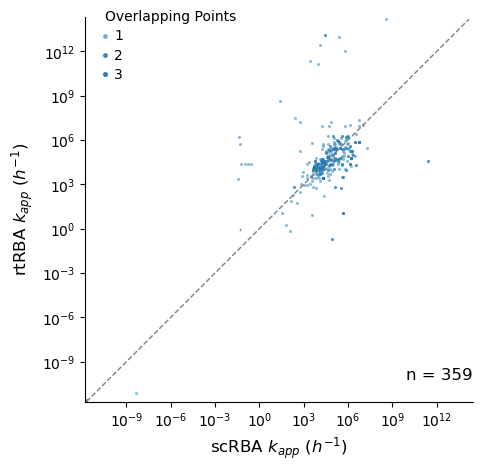

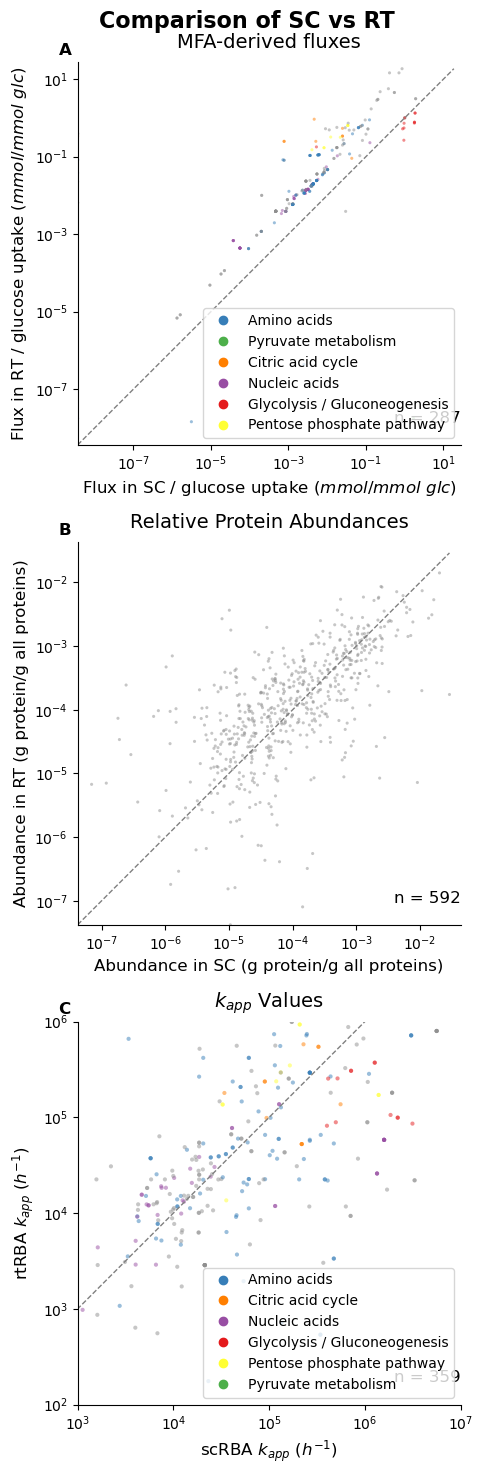

In [ ]:
import openpyxl
letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
# note: currently doesn't support subplots with more than 26 subplots, or cases where 1 row isn't completely used
i=0

# add sheet to new kapp xlsx file for storing each dataset more concisely
plot_data_filename = 'kapp-plots-data.xlsx'
# create new file if it doesn't exist; delete contents if it does
if os.path.exists('./'+plot_data_filename):
	os.remove('./'+plot_data_filename)
# create new file with blank sheet
with pd.ExcelWriter(plot_data_filename) as writer:
	# write message to blank sheet
	df = pd.DataFrame({'Message': ['This file contains data used by kapp_plot.ipynb for generating plots']})
	df.to_excel(writer, sheet_name='Notes')
	# add title to sheet
	# wb = openpyxl.load_workbook(plot_data_filename)
	# ws = wb.active
	# ws['A1'] = d['title']
	# wb.save(plot_data_filename)

with pd.ExcelWriter(plot_data_filename, mode='a') as writer:
	for d in datasets:
		df = pd.DataFrame({'id':d['id'],d['xlabel']: d['x'], d['ylabel']: d['y']})
		# open(plot_data_filename, 'w').close()
		# add new sheet to the file, not overwriting existing sheets
		df.to_excel(writer, sheet_name=d['title'],index=False)
	for d in datasets[len(datasets)-1:]: # needed to ensure multi-plot figure is created properly
		# datacolors = ['#8F8F8F']*len(d['x'])
		# if d['title'] == '$k_{app}$ Values':
		# # set color for each point based on subsystem
		# 	for c in range(len(d['x'])):
		# 		# central carbon metabolism
		# 		if df_kapp.iloc[c]['subsystem'] in ['Glycolysis / Gluconeogenesis']:
		# 			datacolors[c] = '#FF0000'
		fig, ax = plot_2d_data(d, x=d['x'], y=d['y'], xlabel=d['xlabel'], ylabel=d['ylabel'], output_path=d['output_path'],scale='log',show_figure=False,global_fig_ax=True,pointsize=5)
		# save figure
		# make dataframe with xlabel and ylabel, and their respective datasets below them
		# d['y'].to_excel(writer, sheet_name='y')
		# add title to sheet
		# wb = openpyxl.load_workbook(plot_data_filename)
		# ws = wb.active
		# ws['A1'] = d['title']
		# wb.save(plot_data_filename)
	# add each dataset to a new sheet in the same file
	# with pd.ExcelWriter(plot_data_filename) as writer:
	# 	d['x'].to_excel(writer, sheet_name='x')
	# 	d['y'].to_excel(writer, sheet_name='y')
	# 	# add title to sheet
	# 	wb = openpyxl.load_workbook(plot_data_filename)
	# 	ws = wb.active
	# 	ws['A1'] = d['title']
		# wb.save(plot_data_filename)

# with pd.ExcelWriter(plot_data_filename, mode='a') as writer:

subplots_wide = 1
subplots_high = len(datasets)
axis_margin = 0.05
overlapping_points_in_legend = 0
figs, axes = plt.subplots(subplots_high, subplots_wide, figsize=(subplots_wide*5, subplots_high*5))
row,col=0,0
datacolor_lists = {}
for d in datasets:
	# only use 2D indices if needed
	if subplots_high > 1: 
		if subplots_wide > 1:
			indices = [row,col]
		else:
			indices = row
	else:
		indices = col

	# make list of colors that has 1 copy of '#1f78b4' for each point
	# datacolors = ['#1f78b4']*len(d['x'])
	# datacolors = ['#2062A5']*len(d['x'])
	# datacolors = ['#d7191c']*len(d['x'])
	# datacolors = ['#000000']*len(d['x'])
	datacolors = ['#8F8F8F']*len(d['x'])
	legend_elements = []
	pointsize = 5
	if d['title'] == 'MFA-derived fluxes':
		df_data = df_flux_no_zeros
		# set color for each point based on subsystem
		for c in range(len(d['x'])):
			# nucleic acids
			if df_data.iloc[c]['subsystem'] in ['Purine metabolism','Pyrimidine metabolism']:
				# datacolors[c] = '#77ACCE'
				datacolors[c] = '#984ea3'
				# add to legend
				legend_elements.append(mlines.Line2D([], [], color=datacolors[c], marker='o', linestyle='None', label='Nucleic acids'))
			# amino acids
			if df_data.iloc[c]['subsystem'] in ['Lysine metabolism','Histidine metabolism','Tryptophan metabolism','Valine, leucine and isoleucine metabolism','Arginine and proline metabolism','Cysteine and methionine metabolism','Phenylalanine, tyrosine and tryptophan metabolism','Glycine, serine and threonine metabolism','Alanine, aspartate and glutamate metabolism']:
				# datacolors[c] = '#D7EEF9'
				datacolors[c] = '#377eb8'
				legend_elements.append(mlines.Line2D([], [], color=datacolors[c], marker='o', linestyle='None', label='Amino acids'))
			# central carbon metabolism
			# if df_data.iloc[c]['subsystem'] in ['Oxidative phosphorylation']:
			# 	datacolors[c] = '#0000FF'
			if df_data.iloc[c]['subsystem'] in ['Pyruvate metabolism']:
				# datacolors[c] = '#F5F1B4'
				datacolors[c] = '#4daf4a'
				legend_elements.append(mlines.Line2D([], [], color=datacolors[c], marker='o', linestyle='None', label='Pyruvate metabolism'))
			if df_data.iloc[c]['subsystem'] in ['Pentose phosphate pathway']:
				datacolors[c] = '#ffff33'
				legend_elements.append(mlines.Line2D([], [], color=datacolors[c], marker='o', linestyle='None', label='Pentose phosphate pathway'))
			if df_data.iloc[c]['subsystem'] in ['Citric acid cycle']:
				# datacolors[c] = '#F58453'
				datacolors[c] = '#ff7f00'
				legend_elements.append(mlines.Line2D([], [], color=datacolors[c], marker='o', linestyle='None', label='Citric acid cycle'))
			if df_data.iloc[c]['subsystem'] in ['Glycolysis / Gluconeogenesis']:
				# datacolors[c] = '#FF0000'
				datacolors[c] = '#e41a1c'
				legend_elements.append(mlines.Line2D([], [], color=datacolors[c], marker='o', linestyle='None', label='Glycolysis / Gluconeogenesis'))
	# for kapps, color by subsystem
	elif d['title'] == '$k_{app}$ Values':
		pointsize = 9
		df_data = df_kapp
		# set color for each point based on subsystem
		for c in range(len(d['x'])):
			# nucleic acids
			if df_data.iloc[c]['subsystem'] in ['Purine metabolism','Pyrimidine metabolism']:
				# datacolors[c] = '#77ACCE'
				datacolors[c] = '#984ea3'
				# add to legend
				legend_elements.append(mlines.Line2D([], [], color=datacolors[c], marker='o', linestyle='None', label='Nucleic acids'))
			# amino acids
			if df_data.iloc[c]['subsystem'] in ['Lysine metabolism','Histidine metabolism','Tryptophan metabolism','Valine, leucine and isoleucine metabolism','Arginine and proline metabolism','Cysteine and methionine metabolism','Phenylalanine, tyrosine and tryptophan metabolism','Glycine, serine and threonine metabolism','Alanine, aspartate and glutamate metabolism']:
				# datacolors[c] = '#D7EEF9'
				datacolors[c] = '#377eb8'
				# add to legend
				legend_elements.append(mlines.Line2D([], [], color=datacolors[c], marker='o', linestyle='None', label='Amino acids'))
			# central carbon metabolism
			# if df_data.iloc[c]['subsystem'] in ['Oxidative phosphorylation']:
			# 	datacolors[c] = '#0000FF'
			if df_data.iloc[c]['subsystem'] in ['Pyruvate metabolism']:
				# datacolors[c] = '#F5F1B4'
				datacolors[c] = '#4daf4a'
				# add to legend
				legend_elements.append(mlines.Line2D([], [], color=datacolors[c], marker='o', linestyle='None', label='Pyruvate metabolism'))
			if df_data.iloc[c]['subsystem'] in ['Pentose phosphate pathway']:
				datacolors[c] = '#ffff33'
				# add to legend
				legend_elements.append(mlines.Line2D([], [], color=datacolors[c], marker='o', linestyle='None', label='Pentose phosphate pathway'))
			if df_data.iloc[c]['subsystem'] in ['Citric acid cycle']:
				# datacolors[c] = '#F58453'
				datacolors[c] = '#ff7f00'
				# add to legend
				legend_elements.append(mlines.Line2D([], [], color=datacolors[c], marker='o', linestyle='None', label='Citric acid cycle'))
			if df_data.iloc[c]['subsystem'] in ['Glycolysis / Gluconeogenesis']:
				# datacolors[c] = '#FF0000'
				datacolors[c] = '#e41a1c'
				# add to legend
				legend_elements.append(mlines.Line2D([], [], color=datacolors[c], marker='o', linestyle='None', label='Glycolysis / Gluconeogenesis'))
	datacolor_lists[d['title']] = datacolors
	# add each plot to the figure as formatted by plot_2d_data
	fig, axes[indices] = plot_2d_data(d, x=d['x'], y=d['y'], xlabel=d['xlabel'], ylabel=d['ylabel'], datacolor=datacolors,scale='log',show_figure=False,input_ax=axes[indices],input_fig=fig,global_fig_ax=True,pointsize=pointsize,overlapping_points_in_legend=0)
	# if d['title'] == 'MFA-derived fluxes':
	# 	# color points by subsystem
	# 	# get unique subsystems
	# 	subsystems = df_flux_no_zeros['subsystem'].unique()
	# 	# assign #abd9e9 to points with 'Arginine and proline metabolism' or 'Glycine, serine and threonine metabolism' subsystems
	# 	for subsystem in subsystems:
	# 		df_subsystem = df_flux_no_zeros[df_flux_no_zeros['subsystem'] == subsystem]
	# 		# get color for each subsystem
	# 		if subsystem == 'Arginine and proline metabolism' or subsystem == 'Glycine, serine and threonine metabolism':
	# 			color = '#abd9e9'
	# 		else:
	# 			color = 'black'
	# 		# apply color to points in each subsystem
	# 		axes[indices].scatter(df_subsystem[d['x']], df_subsystem[d['y']], color=color, s=5)
	# add letter (a, b, c, etc.) to each subplot
	axes[indices].text(-0.05, 1.05, letters[i], transform=axes[indices].transAxes, fontsize=12, fontweight='bold', va='top', ha='left')
	i += 1
	# make scale of x-axis equal to scale of y-axis
	axes[indices].set_aspect('equal', adjustable='box')
	# add title; move it up slightly to avoid overlap with subplot
	axes[indices].set_title(d['title'], fontsize=14, pad=10)
	# remove minor ticks
	axes[indices].tick_params(which='minor', length=0)

	# if d['title'] == '$k_{app}$ Values':
	if False:
		# make additional plot just for (10^2, 1) to (10^8, 10^6), shown separately
		# make fig2 and ax2 copies of fig and ax
		from copy import deepcopy
		# fig2 = deepcopy(fig)
		# store current xlim and ylim
		xlim = axes[indices].get_xlim()
		ylim = axes[indices].get_ylim()
		
		axes[indices].set_xlim(10**3, 10**7)
		axes[indices].set_ylim(10**2, 10**6)
		# make points larger
		# axes[indices].scatter(d['x'], d['y'], s=7, color=datacolors, alpha=0.5)

		# ax2 = deepcopy(axes[indices])
		# ax2.set_xlim(10**3, 10**7)
		# ax2.set_ylim(10**2, 10**6)
		# _, _ = plot_2d_data(d, x=d['x'], y=d['y'], xlabel=d['xlabel'], ylabel=d['ylabel'], datacolor=datacolors,scale='log',show_figure=False,input_ax=axes[indices],input_fig=fig,global_fig_ax=True,pointsize=9,overlapping_points_in_legend=0, output_path='../kapps-SC-vs-RT-subset.svg')
		# make all dots larger
		# ax2.scatter(d['x'], d['y'], s=7, color=datacolors, alpha=0.5)
		# show the plot
		# fig2.suptitle('Subset of $k_{app}$ Values', fontsize=16, fontweight='bold')
		# plt.tight_layout()
		# plt.savefig('../kapps-SC-vs-RT-subset.svg', transparent=True)
	# remove duplicate legend entries from legend_elements
	if legend_elements:
		unique_handles = []
		unique_labels = set()
		for elem in legend_elements:
			if elem.get_label() not in unique_labels:
				unique_handles.append(elem)
				unique_labels.add(elem.get_label())
		# add legend for each colored point
		axes[indices].legend(handles=unique_handles, fontsize=10)

	# optional: make gray rectangle around each subplot spanning from top left to bottom right - axis_margin)
	# axes[indices].add_patch(mp.Rectangle((0.025,0.825),0.4,0.99,transform=axes[indices].transAxes, fill=None,edgecolor='0.8',linewidth=1,zorder=5))
	# add subplots in reading order, looping around to next row if necessary
	if col+1 >= subplots_wide:
		row += 1
		col = 0
	else:
		col += 1
# add title
figs.suptitle('Comparison of SC vs RT', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../combined-SC-vs-RT.svg')
plt.show()

xscale and yscale are set to log and log, respectively.
Minimum value in x or y is less than or equal to 0. Setting minimum axis limit to lowest non-zero value.
../fluxes-for-kapps-SC-vs-RT.svg:
y = 1.39x + 0.24
R^2 = 0.0845872645118604
p-value = 2.3829973156336964e-08
../protein-abundances-SC-vs-RT.svg:
y = 0.3x + 0.0
R^2 = 0.2882299562019039
p-value = 1.67834239781522e-45
../kapps-SC-vs-RT.svg:
y = -1.54x + 526540536084.27
R^2 = 1.5465591808865146e-05
p-value = 0.9408089481859856


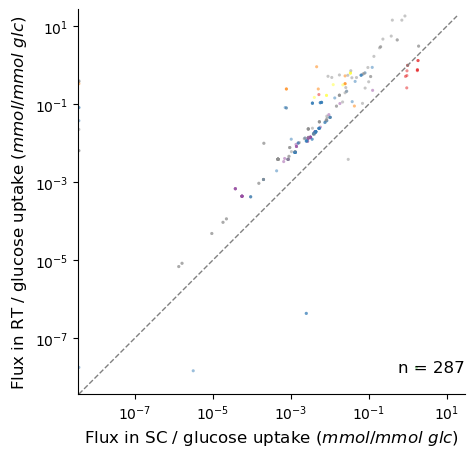

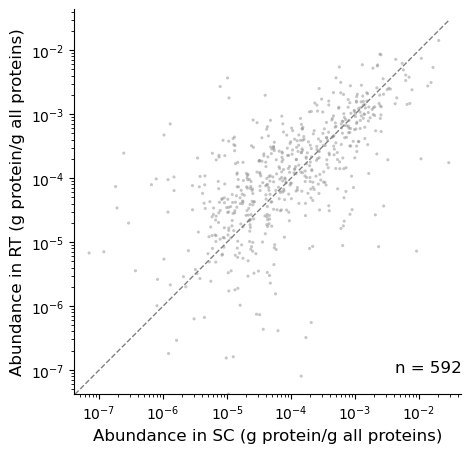

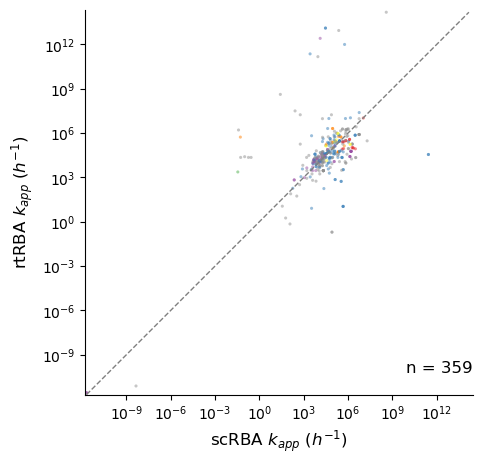

In [10]:
# save to separate files
for d in datasets:
	plot_2d_data(d, x=d['x'], y=d['y'], xlabel=d['xlabel'], datacolor=datacolor_lists[d['title']],ylabel=d['ylabel'], scale='log', output_path=d['output_path'],show_figure=False,global_fig_ax=False,pointsize=5,overlapping_points_in_legend=0)